In [ ]:
# %pip install --upgrade pip --user
# %pip install zarr --user
# %pip install tables --user
# %pip install git+https://github.com/simpeg/simpeg.git@simulation-tdem --user
%pip install dask dask_jobqueue --user
%pip install git+https://github.com/simpeg-research/casingSimulations.git@simulation --user

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import discretize
from scipy import sparse as sp
from scipy.constants import mu_0
import pandas as pd
from pymatsolver import Pardiso
import os
import json
import dask
import dask_jobqueue
from dask.distributed import Client

import casingSimulations as casing_sim

import tensorflow as tf

# we are in the midst of upgrading the API, so this is 
# more closely in-line with the upcoming changes
from SimPEG.electromagnetics import time_domain as tdem

%matplotlib inline

In [110]:
data_directory = "./experiment1"
df = pd.read_hdf(f"{data_directory}/trial_data.h5", "data")

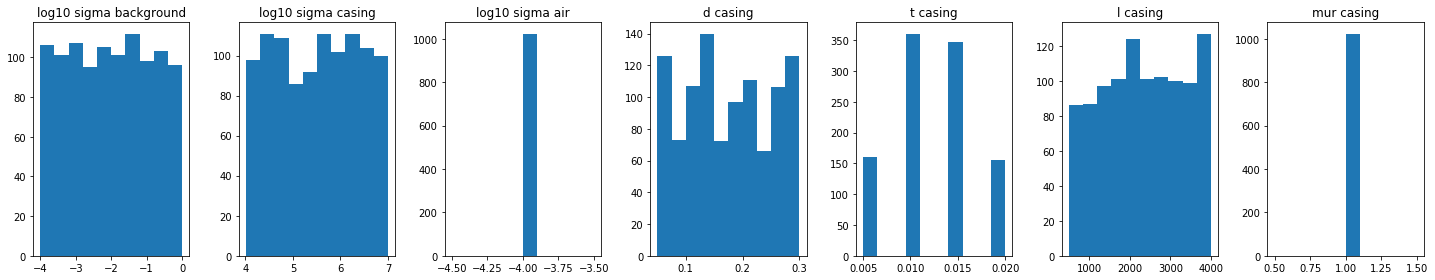

In [111]:
fig, ax = plt.subplots(1,len(df.keys()), figsize=(20, 4))

for i, key in enumerate(df.keys()):
    ax[i].hist(df[key])
    ax[i].set_title(f"{key}".replace("_", " "))

plt.tight_layout()

In [112]:
# pick a single model to try training on 
trial_index = 5  # a 1200 m long well (relatively short --> fast simulations)

trial_directory = f"{data_directory}/trial_{trial_index}"

In [113]:
# generate the 2D model 

with open(f"{trial_directory}/approx_casing.json") as f: 
    params = json.load(f)
model = casing_sim.model.CasingInHalfspace.deserialize(params, trusted=True)

with open(f"{trial_directory}/simulation_approx_casing.json") as f:
    simulation_params = json.load(f)
    
sim3D = tdem.Problem3D_j.deserialize(simulation_params, trusted=True)
mesh3D = sim3D.mesh

In [114]:
# create a 2D simulation
mesh = discretize.CylMesh([mesh3D.hx, 1, mesh3D.hz], x0=mesh3D.x0)
sim = tdem.Problem3D_j(mesh=mesh, time_steps=sim3D.time_steps, solver=Pardiso, sigma=model.sigma(mesh))


(-2000, 10)

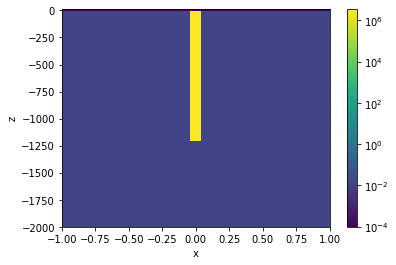

In [115]:
fig, ax = plt.subplots(1, 1)
plt.colorbar(
    mesh.plotImage(
        sim.sigma, ax=ax, pcolorOpts={"norm":LogNorm()}, mirror=True
    )[0], ax=ax
)
ax.set_xlim([-1, 1])
ax.set_ylim([-2000, 10])

In [116]:
def getRHS(sim, source):
    # full source term 
    # rhs = -1./dt * (s_e - s_en1) + C * MeMuI * s_m

    # we are setting s_e to zero
    rhs = sim.mesh.edgeCurl * (sim.MeMuI * source)
    if sim._makeASymmetric:
        return sim.MfRho.T * rhs
    return rhs

In [117]:
def getRHS_deriv(sim, v=None, adjoint=False):

    # full source term 
    # rhs = -1./dt * (s_e - s_en1) + C * MeMuI * s_m
    # we are setting s_e to zero
    mesh = sim.mesh
    
    if adjoint:
        if sim._makeASymmetric:
            if v is not None: 
                rhs = sim.MfRho * v
            else:
                rhs = sim.MfRho
        else:
            rhs = v if v is not None else sp.eye(mesh.nF)
        return sim.MeMuI.T * (mesh.edgeCurl.T * rhs)
    
    if v is not None:
        rhs = sim.mesh.edgeCurl * (sim.MeMuI * v)
    else:
        rhs = sim.mesh.edgeCurl * sim.MeMuI
    if sim._makeASymmetric:
        return sim.MfRho.T * rhs
    return rhs

In [118]:
# solve the forward problem 
def fields(sim, source):
    f = np.zeros((sim.mesh.nF, sim.nT+1))

    # timestep to solve forward
    Ainv = None
    for tInd, dt in enumerate(sim.timeSteps):
        # keep factors if dt is the same as previous step b/c A will be the
        # same
        if Ainv is not None and (
            tInd > 0 and abs(dt-sim.timeSteps[tInd - 1]) >
            sim.dt_threshold
        ):
            Ainv.clean()
            Ainv = None

        if Ainv is None:
            A = sim.getAdiag(tInd)
            Ainv = Pardiso(A)

        rhs = getRHS(sim, source[:, tInd+1])  # this is on the nodes of the time mesh
        Asubdiag = sim.getAsubdiag(tInd)

        # taking a step
        sol = Ainv * (rhs - Asubdiag * f[:, tInd])
        f[:, tInd+1] = sol

    # clean factors and return
    Ainv.clean()
    return f

In [119]:
def fields_deriv(sim, v=None, adjoint=False):
    
    if adjoint:
        return fields_deriv_adjoint(sim, v=v)
    
    df_dm_v = np.zeros((sim.mesh.nF, sim.nT+1))

    # timestep to solve forward
    Ainv = None
    for tInd, dt in enumerate(sim.timeSteps):
        # keep factors if dt is the same as previous step b/c A will be the
        # same
        if Ainv is not None and (
            tInd > 0 and abs(dt-sim.timeSteps[tInd - 1]) > sim.dt_threshold
        ):
            Ainv.clean()
            Ainv = None
        
        if Ainv is None:
            A = sim.getAdiag(tInd)
            Ainv = Pardiso(A)

        rhs_deriv = getRHS_deriv(sim, v[:, tInd+1])  # this is on the nodes of the time mesh
        Asubdiag = sim.getAsubdiag(tInd)

        # taking a step
        sol = Ainv * (rhs_deriv - Asubdiag * df_dm_v[:, tInd])
        df_dm_v[:, tInd+1] = sol

    # clean factors and return
    Ainv.clean()
    return df_dm_v

In [120]:
def fields_deriv_adjoint(sim, v=None):
    
    df_dmT_v = np.zeros((sim.mesh.nE, sim.nT+1))  # the source is defined on edges

    # timestep to solve forward
    ATinv = None
    for tInd in reversed(range(sim.nT)):
        dt = sim.time_steps[tInd]
        # keep factors if dt is the same as previous step b/c A will be the
        # same
        if ATinv is not None and (
            tInd <= sim.nT and abs(dt-sim.timeSteps[tInd + 1]) > sim.dt_threshold
        ):
            ATinv.clean()
            ATinv = None
        
        if ATinv is None:
            AT = sim.getAdiag(tInd).T
            ATinv = Pardiso(AT)    
        
#         ATinv_v = ATinv * v[:, tInd+1]
        if tInd < sim.nT - 1:
            AsubdiagT = sim.getAsubdiag(tInd+1).T
            sol = ATinv * (v[:, tInd+1] - AsubdiagT * sol)
        else: 
            sol = ATinv * v[:, tInd+1]
        rhs_deriv = getRHS_deriv(sim, sol, adjoint=True)  # this is on the nodes of the time mesh
        
        df_dmT_v[:, tInd+1] = rhs_deriv

    # clean factors and return
    ATinv.clean()
    return df_dmT_v

In [143]:
def create_source(sim, model, s, trial_directory):
    # interpolate on to the spatial mesh (lets use exact time for now)
    z_source = np.load(f"{trial_directory}/z_currents.npy")
    mesh = sim.mesh
    src = np.zeros((mesh.nEy, sim.nT+1))
  
    csx = mesh.hx.min()
    
    xinds = (mesh.gridEy[:, 0] < model.casing_b + csx/2) & (mesh.gridEy[:, 0] > model.casing_b - csx/2)
    zinds = (mesh.gridEy[:, 2] >= model.casing_z.min()) & (mesh.gridEy[:, 2] <= model.casing_z.max())
    src_inds_bool = xinds & zinds
    src_inds = np.where(src_inds_bool)[0]
    
    P = discretize.utils.interpmat(mesh.gridEy[src_inds, 2], z_source)

    src[src_inds, :] = P * s
    
    def grad(dy, adjoint=True):
        if adjoint:
            return P.T * dy[src_inds, :]
        grd = np.zeros((mesh.nEy, sim.nT+1))
        grd[src_inds, :] = P * dy
        return grd
    
    return src, grad
                  

In [122]:
def load_trial(trial_directory):
    # load up the data
    with open(f"{trial_directory}/approx_casing.json") as f: 
        params = json.load(f)
    model = casing_sim.model.CasingInHalfspace.deserialize(params, trusted=True)

    with open(f"{trial_directory}/simulation_approx_casing.json") as f:
        simulation_params = json.load(f)

    sim3D = tdem.Problem3D_j.deserialize(simulation_params, trusted=True)
    mesh3D = sim3D.mesh
    
    mesh = discretize.CylMesh([mesh3D.hx, 1, mesh3D.hz], x0=mesh3D.x0)
    sim = tdem.Problem3D_j(mesh=mesh, time_steps=sim3D.time_steps, solver=Pardiso, sigma=model.sigma(mesh))

    return model, mesh, sim

In [123]:
def get_j_interpolation_mat(
    trial_directory, mesh, 
    log10tmin=-6, log10tmax=-2, ntimes=128 # hard-coded from "pipeline_synthetic_data"
):
    xsample = np.load(f"{trial_directory}/x.npy")
    zsample = np.load(f"{trial_directory}/z.npy")
    xz_grid = discretize.utils.ndgrid(xsample, np.r_[0], zsample)
    
    Px = mesh.getInterpolationMat(xz_grid, 'Fx')
    Pz = mesh.getInterpolationMat(xz_grid, 'Fz') 
    
    tsample = np.logspace(log10tmin, log10tmax, ntimes)
    Pt = sim.time_mesh.getInterpolationMat(tsample, 'N')

    # construct full P
    Pxt = sp.kron(Pt, Px)
    Pzt = sp.kron(Pt, Pz)
    P = sp.vstack([Pxt, Pzt])

    return P
    

In [158]:
def run_forward(trial_ind, source_vec):
    trial_directory = f"{data_directory}/trial_{trial_ind}"
    model, mesh, sim = load_trial(trial_directory)
    
    source, source_grad = create_source(sim, model, source_vec, trial_directory)
    f = fields(sim, source)
    P = get_j_interpolation_mat(trial_directory, mesh)
    j_compare = P * discretize.utils.mkvc(f)
    
    def grad(dy, adjoint=True):  
        if adjoint: 
            v = P.T * dy
            v = v.reshape(mesh.nF, sim.nT+1, order="F")
            f_deriv = fields_deriv_adjoint(sim, v)
            return source_grad(f_deriv, adjoint=True)
        f_deriv = fields_deriv(sim, source_grad(dy, adjoint=False))
        return P * discretize.utils.mkvc(f_deriv)
        
    return j_compare, grad

# set up a simple test example 

In [125]:
def waveform(t, t_peak=5e-3, width=10, amplitude=1):
    t = np.log10(t)
    t_peak = np.log10(t_peak)
    width = np.log10(width)
    return amplitude * np.exp(-(t - t_peak)**2/(2*width**2))

def sigmoid(x, x0=0, slope=1):
    return np.arctan(slope * (x-x0))/np.pi + 0.5

def depth_distribution(z, dz=200, slope=1e-1):
    return sigmoid(z, model.casing_z.min() + dz, slope) * sigmoid(-z, -(model.casing_z.max() - dz), slope)

def source_sm(mesh, t, z):
    sm = np.zeros(mesh.nE)
    sm = np.outer(depth_distribution(z), waveform(t))
    
    return sm

In [126]:
z = np.load(f"{trial_directory}/z_currents.npy")
src_vec = source_sm(mesh, sim.times, z)

/usr/common/software/tensorflow/gpu-tensorflow/1.13.1-py36/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


Text(0, 0.5, 'z')

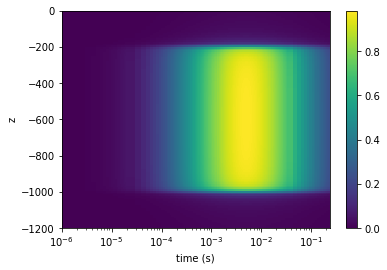

In [127]:
fig, ax = plt.subplots(1, 1)
plt.colorbar(ax.pcolormesh(sim.times, z, src_vec), ax=ax)
ax.set_xscale("log")
ax.set_xlim(1e-6, sim.times.max())
ax.set_xlabel("time (s)")
ax.set_ylabel("z")

In [128]:
def test_source(source):   
    source = source.reshape(128, 191, order="F")
    src, grad = create_source(sim, model, source, trial_directory)
    
    def src_deriv(dy, adjoint=False):
        if not adjoint: 
            dy = dy.reshape(128, 191, order="F")
        else:
            dy = dy.reshape(mesh.nE, 191, order="F")
        return discretize.utils.mkvc(grad(dy, adjoint))
    
    return discretize.utils.mkvc(src), src_deriv

x0 = discretize.utils.mkvc(src_vec)
discretize.Tests.checkDerivative(
    test_source,
    x0=x0*0,
    num=4, 
    plotIt=False, 
)

==================== checkDerivative ====================
iter    h         |ft-f0|   |ft-f0-h*J0*dx|  Order
---------------------------------------------------------
 0   1.00e-01    1.763e+01     2.064e-15      nan
 1   1.00e-02    1.763e+00     2.076e-16      0.997
 2   1.00e-03    1.763e-01     2.042e-17      1.007
 3   1.00e-04    1.763e-02     2.052e-18      0.998
========================= PASS! =========================
Well done Lheagy!



True

In [129]:
# adjoint test

src_vec = discretize.utils.mkvc(src_vec.reshape(128, 191, order="F"))
src, src_deriv = test_source(src_vec)

v = np.random.rand(128*191)
w = np.random.rand(mesh.nE*191)

a = w.T.dot(discretize.utils.mkvc(src_deriv(v.reshape(128, 191, order="F"), adjoint=False)))
b = v.T.dot(discretize.utils.mkvc(src_deriv(w, adjoint=True)))

print(f"{np.linalg.norm(a):1.3e}, {np.linalg.norm(b):1.3e}, {np.linalg.norm(a-b):1.3e}")

1.162e+04, 1.162e+04, 3.638e-12


In [134]:
def test_rhs(source):   
    source = source.reshape(128, 191, order="F")
    src, grad_src = create_source(sim, model, source, trial_directory)
    rhs = getRHS(sim, src)
    
    def src_deriv(dy, adjoint=False):
        if not adjoint:
            dy = dy.reshape(128, 191, order="F")
            return discretize.utils.mkvc(getRHS_deriv(sim, grad_src(dy, adjoint), adjoint))
        else: 
            dy = dy.reshape(mesh.nF, 191, order="F")
            return grad_src(getRHS_deriv(sim, dy, adjoint), adjoint)        
    
    return discretize.utils.mkvc(rhs), src_deriv

x0 = discretize.utils.mkvc(src_vec)
discretize.Tests.checkDerivative(
    test_rhs,
    x0=0*x0,
#     dx=1e-3*x0,
    num=4, 
    plotIt=False, 
    expectedOrder=1,
)

==================== checkDerivative ====================
iter    h         |ft-f0|   |ft-f0-h*J0*dx|  Order
---------------------------------------------------------
 0   1.00e-01    1.583e+12     2.014e-04      nan
 1   1.00e-02    1.583e+11     1.942e-05      1.016
 2   1.00e-03    1.583e+10     2.160e-06      0.954
 3   1.00e-04    1.583e+09     1.988e-07      1.036
========================= PASS! =========================
You get a gold star!



True

In [131]:
# adjoint test

src_vec = discretize.utils.mkvc(src_vec.reshape(128, 191, order="F"))
rhs, rhs_deriv = test_rhs(src_vec)

v = np.random.rand(128*191)
w = np.random.rand(mesh.nF*191)

a = w.T.dot(discretize.utils.mkvc(rhs_deriv(v.reshape(128, 191, order="F"), adjoint=False)))
b = v.T.dot(discretize.utils.mkvc(rhs_deriv(w, adjoint=True)))

print(f"{np.linalg.norm(a):1.3e}, {np.linalg.norm(b):1.3e}, {np.linalg.norm(a-b):1.3e}")

1.138e+14, 1.138e+14, 1.094e-01


In [ ]:
src_sm, _ = create_source(sim, model, src_vec.reshape(128, 191, order="F"), trial_directory)

def test_forward(src_sm):
    src_sm = src_sm.reshape(mesh.nEy, sim.nT+1, order="F")
    j = fields(sim, src_sm)
    
    def j_deriv(v, adjoint=False):
        if not adjoint:
            v = v.reshape(mesh.nEy, sim.nT+1, order="F")
            return discretize.utils.mkvc(fields_deriv(sim, v, adjoint))
        else:
            v = v.reshape(mesh.nF, sim.nT+1, order="F")
            return fields_deriv(sim, v, adjoint)
    return discretize.utils.mkvc(j), j_deriv

x0 = discretize.utils.mkvc(src_sm)
discretize.Tests.checkDerivative(
    test_forward,
    x0=x0,
    num=4, 
    plotIt=False, 
    expectedOrder=1,
)

In [150]:
# adjoint test

j, j_deriv = test_forward(src_sm)

v = np.random.rand(np.prod(src_sm.shape))
w = np.random.rand(np.prod(j.shape))

a = w.T.dot(discretize.utils.mkvc(j_deriv(v, adjoint=False)))
b = v.T.dot(discretize.utils.mkvc(j_deriv(w, adjoint=True)))

print(f"{np.linalg.norm(a):1.3e}, {np.linalg.norm(b):1.3e}, {np.linalg.norm(a-b):1.3e}")

7.401e+11, 7.401e+11, 2.579e-01


In [159]:
def test_forward_full(src_vec):
    src_vec = src_vec.reshape(128, 191, order="F")
    j, j_deriv = run_forward(5, src_vec)
    
    def grad(v):
        v = v.reshape(128, 191, order="F")
        return discretize.utils.mkvc(j_deriv(v, adjoint=False))
    return discretize.utils.mkvc(j), grad

x0 = discretize.utils.mkvc(src_vec)
discretize.Tests.checkDerivative(
    test_forward_full,
    x0=0*x0,
    num=5, 
    plotIt=False, 
    expectedOrder=1,
)

==================== checkDerivative ====================
iter    h         |ft-f0|   |ft-f0-h*J0*dx|  Order
---------------------------------------------------------
 0   1.00e-01    1.825e-02     2.234e-13      nan
 1   1.00e-02    1.825e-03     3.481e-15      1.807
 2   1.00e-03    1.825e-04     2.145e-15      0.210
 3   1.00e-04    1.825e-05     1.890e-16      1.055
 4   1.00e-05    1.825e-06     1.017e-17      1.269
========================= PASS! =========================
Testing is important.



True

In [152]:
# adjoint test

src_vec = src_vec.reshape(128, 191, order="F")
j, j_deriv = run_forward(5, src_vec)

v = np.random.rand(128*191)
w = np.random.rand(np.prod(j.shape))

a = w.T.dot(discretize.utils.mkvc(j_deriv(v.reshape(128, 191, order="F"), adjoint=False)))
b = v.T.dot(discretize.utils.mkvc(j_deriv(w, adjoint=True)))

err = a-b
if np.linalg.norm(err)/np.linalg.norm(a) < 1e-10:
    passing = True
else: 
    passing = False
    
print(
    f"{np.linalg.norm(a):1.3e}, "
    f"{np.linalg.norm(b):1.3e}, "
    f"{np.linalg.norm(err):1.3e}, "
    f"{'passing :)' if passing is True else 'failing :('}"
)

7.274e+00, 7.274e+00, 8.013e-12, passing :)


In [153]:
src_sm, _ = create_source(sim, model, src_vec, trial_directory)
src_sm = src_sm.reshape(mesh.nEy, sim.nT+1, order="F")
j = fields(sim, src_sm)

Text(0.5, 1.0, 'current density, t=1.2e-01ms')

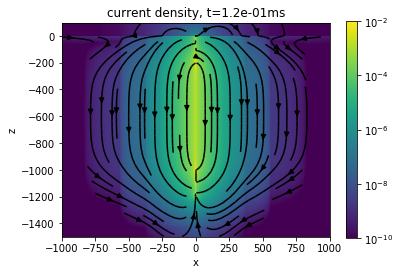

In [154]:
tind = 30
fig, ax = plt.subplots(1, 1)

out = mesh.plotImage(
    mesh.aveF2CCV * j[:, tind], 
    view="vec",
    vType="CCv",
    ax=ax, mirror=True,
    range_x=np.r_[-1000, 1000], 
    range_y=np.r_[-1500, 100],
    sample_grid = np.r_[5., 5.],
    pcolorOpts={"norm":LogNorm()},
    clim = np.r_[1e-10, 1e-2], 
    stream_threshold = 1e-10
)
ax.set_aspect(1)
plt.colorbar(out[0])

ax.set_title(f"current density, t={sim.times[tind]*1e3:1.1e}ms")

Text(0.5, 1.0, 'source term, t=1.0e-02ms')

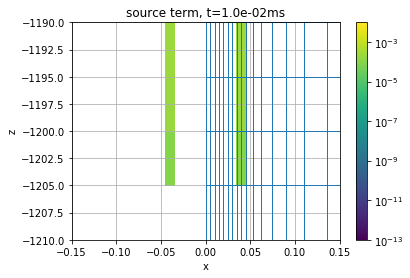

In [155]:
tind = 10
fig, ax = plt.subplots(1, 1)

out = mesh.plotImage(
    mesh.aveE2CC * src_sm[:, tind], 
#     view="vec",
#     vType="CCv",
    ax=ax, mirror=True,
    range_x=0.15*np.r_[-1, 1], 
    range_y=np.r_[-1210, -1190], #10*np.r_[-1, 1],
#     sample_grid = np.r_[5., 5.],
    pcolorOpts={"norm":LogNorm()},
    clim = np.r_[1e-13, 1e-2], 
#     stream_threshold = 1e-13
)
mesh.plotGrid(ax=ax)
# ax.set_aspect(1)
plt.colorbar(out[0])

ax.set_title(f"source term, t={sim.times[tind]*1e3:1.1e}ms")

# Set up ML pipeline

In [174]:
nspatial = 128
ntimes = 191
nsrcz = 128

In [181]:
# @tf.custom_gradient
# def tf_run_forward(trial_ind, source_vec):
#     trial_directory = f"{data_directory}/trial_{trial_ind}"
#     model, mesh, sim = load_trial(trial_directory)
    
#     source, source_grad = create_source(sim, model, source_vec, trial_directory)
#     f = fields(sim, source)
#     P = get_j_interpolation_mat(trial_directory, mesh)
#     j_compare = (P * discretize.utils.mkvc(f)).astype("float32")
#     j_compare.set_shape([nspatial*ntimes])
    
#     def grad(dy, adjoint=True):  
#         if adjoint: 
#             v = P.T * dy
#             v = v.reshape(mesh.nF, sim.nT+1, order="F")
#             f_deriv = fields_deriv_adjoint(sim, v)
#             grd = source_grad(f_deriv, adjoint=True).astype("float32")
#             grd.set_shape([nspatial, ntimes])
#             return grd
#         else:   # you can ignore this, just needed for testing 
#             f_deriv = fields_deriv(sim, source_grad(dy, adjoint=False))
#             return (P * discretize.utils.mkvc(f_deriv)).astype("float32")
        
#     return j_compare, grad

@tf.custom_gradient
def tf_run_forward(trial_ind, source_vec):
    j, j_deriv = tf.py_function(
        run_forward, [trial_ind, src_vec], Tout=(tf.float32, tf.float32)
    )
    
    def grad(v):
        v = v.reshape(128, 191, order="F")
        return discretize.utils.mkvc(j_deriv(v, adjoint=False))
    return j, j_deriv 



In [ ]:
def get_weights(jdiff, std=0.05, floor=1e-11)
    return (1./(std * np.abs(jdiff) + floor)).astype("float32")

In [182]:
tf.reset_default_graph()

loss = 0
for trial_index in [5]:
    trial_directory = f"{data_directory}/trial_{trial_index}"
    
    # fixed variables
    
    j_diff = tf.placeholder(shape=(nspatial*ntimes,), dtype=tf.float32)
    
    # source and computation of fields
    tf_source = tf.get_variable(
        shape=(nsrcz, ntimes), dtype=tf.float32, 
        name='tf_source', initializer=tf.zeros_initializer()
    )
    j_compare = tf_run_forward(trial_index, tf_source)
    
    jd = np.load(f"{trial_directory}/j_difference.npy")
    w_tf = tf.py_function()
    j_diff.assign(jd.astype("float32"))
    
    w_tf = tf.assign(get_weights(jd).astype("float32"))
    loss = loss + tf.reduce_sum(tf.multiply(w_tf, (j_compare - jdiff))**2)

AttributeError: module 'tensorflow' has no attribute 'function'